In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = "/content/drive/My Drive/UnorganizedDataset"  # Path to the dataset
output_dir = "output_data"  # Path to the split dataset

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio):
    # Loop through each class
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files

        # Collect all image paths
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        if len(images) < 3:  # Ensure minimum images for splitting
            print(f"Skipping '{class_name}' (not enough images for splitting).")
            continue

        # Perform the split
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        # Create and populate train, val, test directories
        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, split_dir)

# Call the function
split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio)

print("Dataset has been successfully split into train, val, and test!")


Dataset has been successfully split into train, val, and test!


In [4]:
# Paths
train_dir = "output_data/train"
val_dir = "output_data/val"
test_dir = "output_data/test"

# Parameters
img_size = (224, 224)  # Standard for MobileNetV2
batch_size = 32
epochs = 20
learning_rate = 0.0001

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Load NASNetMobile model
base_model = NASNetMobile(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1,
)

# Save the trained model
model.save("coconut_nasnetmobile_model.h5")

# Test the model (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)


Found 2712 images belonging to 4 classes.
Found 582 images belonging to 4 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4842 - loss: 1.2035 - val_accuracy: 0.8969 - val_loss: 0.4014
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 762ms/step - accuracy: 0.8338 - loss: 0.4813 - val_accuracy: 0.9416 - val_loss: 0.2438
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 750ms/step - accuracy: 0.9046 - loss: 0.2974 - val_accuracy: 0.9467 - val_loss: 0.1893
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 754ms/step - accuracy: 0.9239 - loss: 0.2402 - val_accuracy: 0.9553 - val_loss: 0.1579
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 750ms/step - accuracy: 0.9413 - loss: 0.1934 - val_accuracy: 0.9605 - val_loss: 0.1363
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 754ms/step - accuracy: 0.9482 - loss: 0.1709 - val_accuracy: 0.9622 - val_loss: 0.1168
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 742ms/step - accuracy: 0.9521 - loss: 0.1449 - val_accuracy: 0.9674 - val_loss: 0.1045
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 72s 792ms/step - accuracy: 0.9648 - loss: 0.1320 - val_accuracy: 0.9691 

Found 584 images belonging to 4 classes.


In [5]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.9887 - loss: 0.0501
Validation Accuracy: 98.28%
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 933ms/step - accuracy: 0.9824 - loss: 0.0465
Test Accuracy: 97.60%


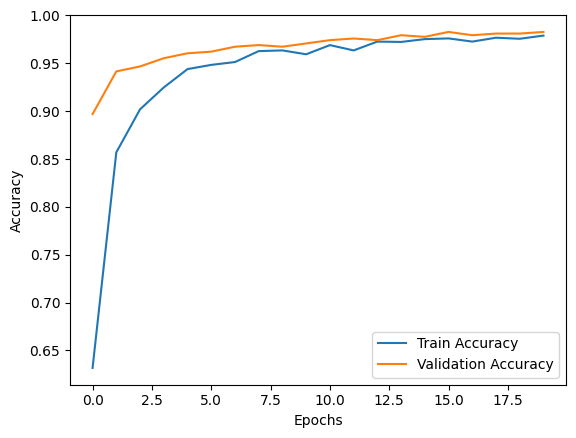

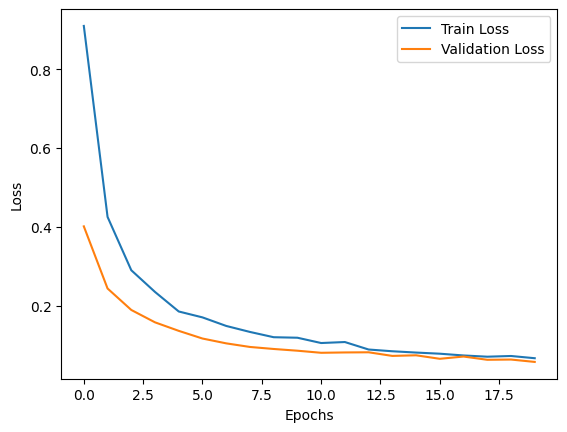

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Confusion Matrix:
[[30 22 45 43]
 [29 18 37 30]
 [43 37 54 44]
 [33 36 42 41]]
Classification Report:
              precision    recall  f1-score   support

      Mature       0.22      0.21      0.22       140
  NonCoconut       0.16      0.16      0.16       114
         Old       0.30      0.30      0.30       178
       Young       0.26      0.27      0.26       152

    accuracy                           0.24       584
   macro avg       0.24      0.24      0.24       584
weighted avg       0.24      0.24      0.24       584



1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


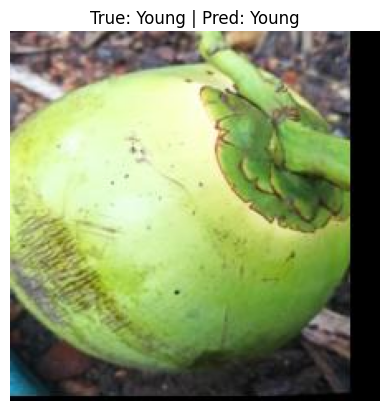

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


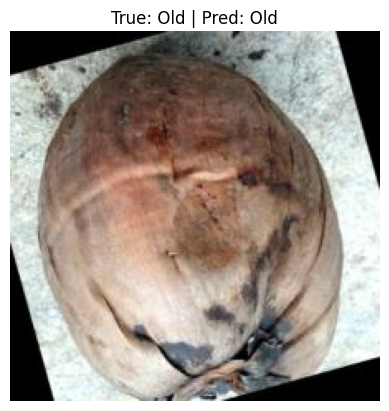

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


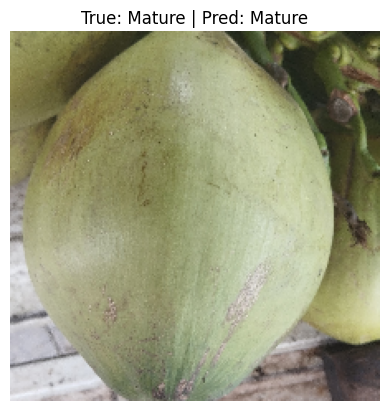

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


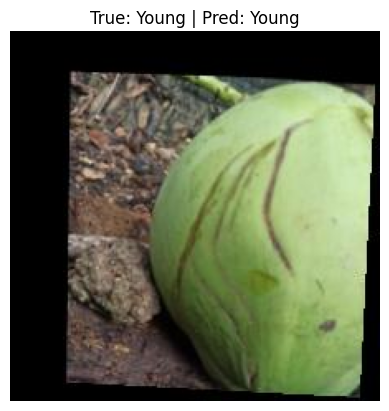

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


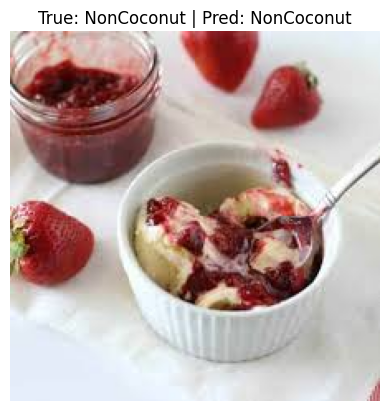

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


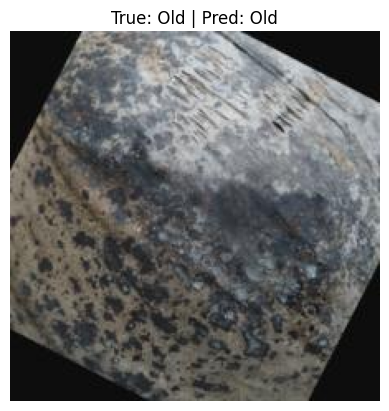

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


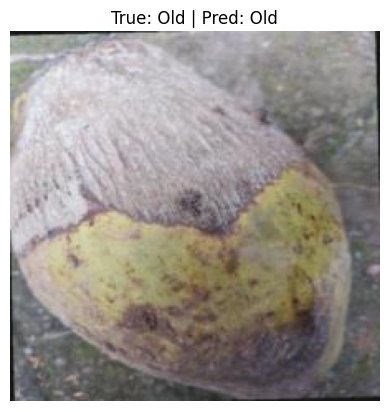

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


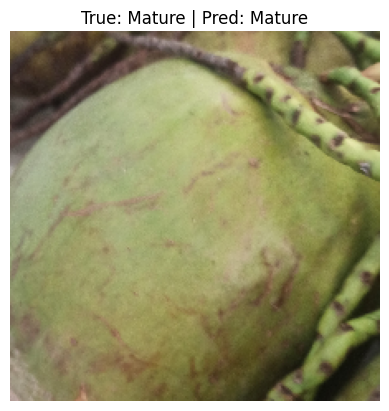

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


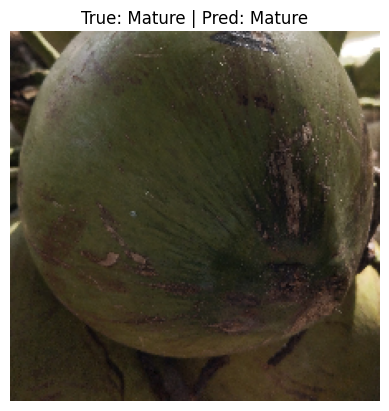

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


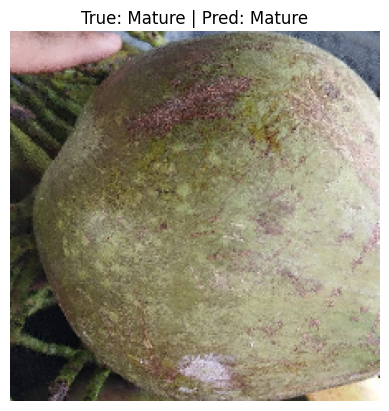

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Iterate over the test generator
for i, (img, label) in enumerate(test_generator):  # Unpack batches from the generator
    if i >= 10:  # Show only the first 10 test images
        break

    # Predict the class
    pred = model.predict(img)
    pred_label = class_labels[np.argmax(pred[0])]
    true_label = class_labels[np.argmax(label[0])]

    # Display the image
    plt.imshow(img[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()
